In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
SC=StandardScaler()
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBRFClassifier,XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      300000 non-null  int64 
 1   bin_0   300000 non-null  int64 
 2   bin_1   300000 non-null  int64 
 3   bin_2   300000 non-null  int64 
 4   bin_3   300000 non-null  object
 5   bin_4   300000 non-null  object
 6   nom_0   300000 non-null  object
 7   nom_1   300000 non-null  object
 8   nom_2   300000 non-null  object
 9   nom_3   300000 non-null  object
 10  nom_4   300000 non-null  object
 11  nom_5   300000 non-null  object
 12  nom_6   300000 non-null  object
 13  nom_7   300000 non-null  object
 14  nom_8   300000 non-null  object
 15  nom_9   300000 non-null  object
 16  ord_0   300000 non-null  int64 
 17  ord_1   300000 non-null  object
 18  ord_2   300000 non-null  object
 19  ord_3   300000 non-null  object
 20  ord_4   300000 non-null  object
 21  ord_5   300000 non-null  object
 

In [5]:
train.head(1)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0


In [15]:
from scipy.stats import chi2_contingency
## Lets test Chisquare test of Independence to find out whoch all features are of importnce.
# Assume Sugnificance level =0.05
# Ho: There is no significant dependency between Categorical feature(X1 Or X2...or Xn) and Label:target
# H1: There is no  dependency between Categorical feature(X1 Or X2...or Xn) and Label:target
# If the Actual p-value computed from Chisquare test is < 0.05 then we reject the NULL hypothesis
        #(Means there is dependency betwen X and y and we can retain the feature)
# If the Actual p-value computed from Chisquare test is >= 0.05 then we fail to reject the NULL hypothesis
         #(Means there is no dependency betwen X and y and we can drop the feature)
# The basic requirement of Chisquare test is: All variables should be Categorical.
train=train.astype('object')
train.info()
# Select all catagorical columns except target
categorical_columns=list(train.select_dtypes(include='object').drop(columns=['id','target']).columns)
categorical_columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      300000 non-null  object
 1   bin_0   300000 non-null  object
 2   bin_1   300000 non-null  object
 3   bin_2   300000 non-null  object
 4   bin_3   300000 non-null  object
 5   bin_4   300000 non-null  object
 6   nom_0   300000 non-null  object
 7   nom_1   300000 non-null  object
 8   nom_2   300000 non-null  object
 9   nom_3   300000 non-null  object
 10  nom_4   300000 non-null  object
 11  nom_5   300000 non-null  object
 12  nom_6   300000 non-null  object
 13  nom_7   300000 non-null  object
 14  nom_8   300000 non-null  object
 15  nom_9   300000 non-null  object
 16  ord_0   300000 non-null  object
 17  ord_1   300000 non-null  object
 18  ord_2   300000 non-null  object
 19  ord_3   300000 non-null  object
 20  ord_4   300000 non-null  object
 21  ord_5   300000 non-null  object
 

['bin_0',
 'bin_1',
 'bin_2',
 'bin_3',
 'bin_4',
 'nom_0',
 'nom_1',
 'nom_2',
 'nom_3',
 'nom_4',
 'nom_5',
 'nom_6',
 'nom_7',
 'nom_8',
 'nom_9',
 'ord_0',
 'ord_1',
 'ord_2',
 'ord_3',
 'ord_4',
 'ord_5',
 'day',
 'month']

In [25]:
chi2_check = []
for i in categorical_columns:
    ch2 , p_value , df, exp_freq=chi2_contingency(pd.crosstab(train[i],train['target']))
    if p_value < 0.05:
        chi2_check.append('Reject Null Hypothesis: Retain the Feature:')
    else:
        chi2_check.append('Fail to Reject Null Hypothesis: Drop the Feature:')
        
result = pd.DataFrame(chi2_check,columns=['Remarks'])
result.insert(0,'Feature',categorical_columns)
result


,Feature,Remarks
0,bin_0,Fail to Reject Null Hypothesis: Drop the Feature:
1,bin_1,Reject Null Hypothesis: Retain the Feature:
2,bin_2,Reject Null Hypothesis: Retain the Feature:
3,bin_3,Reject Null Hypothesis: Retain the Feature:
4,bin_4,Reject Null Hypothesis: Retain the Feature:
5,nom_0,Reject Null Hypothesis: Retain the Feature:
6,nom_1,Reject Null Hypothesis: Retain the Feature:
7,nom_2,Reject Null Hypothesis: Retain the Feature:
8,nom_3,Reject Null Hypothesis: Retain the Feature:
9,nom_4,Reject Null Hypothesis: Retain the Feature:


In [ ]:
# from above test it seems that only one feature bin_0 could be dropped.

In [47]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
# Preprocessing of Train and test Data together
#Concatenate Train and Test Data with a new column to identify Train (Type=0) VS Test Data(Type=1)  
train['Type']=pd.DataFrame(np.zeros(len(train)).astype(int))
test['Type']=pd.DataFrame(np.ones(len(test)).astype(int))

print('Original Train Data shape:{} and Test Data shape:{}'.format(train.shape,test.shape))
features_Data=pd.concat([train.drop(columns=['target','id']),test.drop(columns=['id'])])
print('features_Data shape after combining Train and Test ',features_Data.shape)
label=train.target

Original Train Data shape:(300000, 26) and Test Data shape:(200000, 25)
features_Data shape after combining Train and Test  (500000, 24)


,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,Type
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0


In [48]:
# Lets do some EDA
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
features_Data.head()


,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,Type
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,0
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


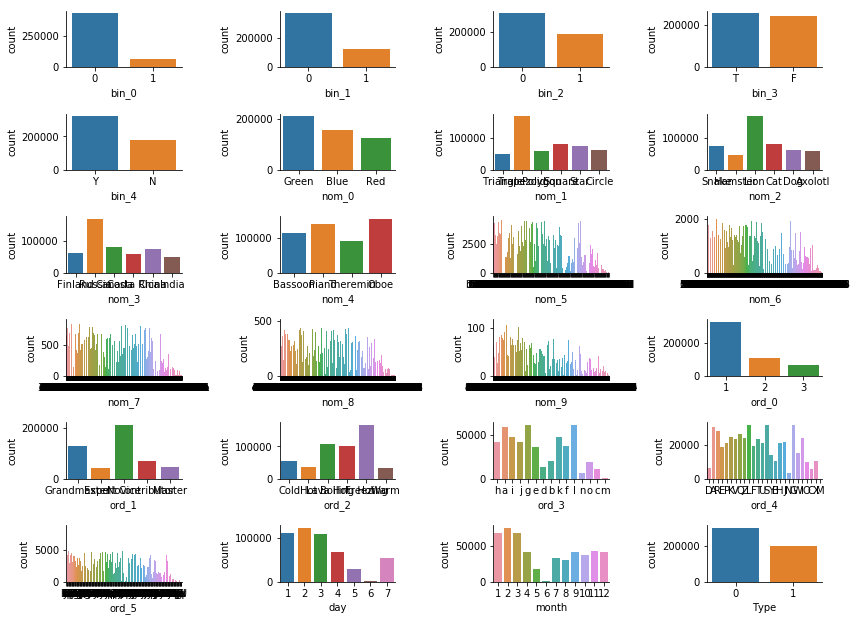

In [49]:
# Count plot
plt.figure(figsize=[12,14])
features=list(features_Data.columns)
n=1
for f in features:
    plt.subplot(10,4,n)
    sns.countplot(features_Data[f])
    sns.despine()
    n=n+1
plt.tight_layout()
plt.show()

In [ ]:
pd.set_option('display.max_rows', 400)
features_Data.nom_5.value_counts().shape # 222 distinct categories
features_Data.nom_6.value_counts().shape # 522 distinct categories
features_Data.nom_7.value_counts().shape # 1220 distinct categories
features_Data.nom_8.value_counts().shape # 2219 distinct categories
features_Data.nom_9.value_counts().shape # 12068 distinct categories
features_Data.ord_5.value_counts().shape # 192 distinct categories

In [6]:
features_Data.head(1)

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,Type
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0


In [50]:
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,LabelBinarizer
# Handling of Binary Features
LB=LabelBinarizer()                           
features_Data['bin_3']=LB.fit_transform(features_Data.bin_3)
features_Data['bin_4']=LB.fit_transform(features_Data.bin_4)

# Handling of Nominal Features
LE=LabelEncoder()
features_nom=features_Data.loc[:,['nom_0','nom_1','nom_2','nom_3','nom_4','nom_5','nom_6','nom_7','nom_8','nom_9']]
features_nom=features_nom.apply(LE.fit_transform)
features_Data[['nom_0','nom_1','nom_2','nom_3','nom_4','nom_5','nom_6','nom_7','nom_8','nom_9']]=features_nom

# Handling of Ordinal Features
OE=OrdinalEncoder()
features_ord=features_Data.loc[:,['ord_1','ord_2','ord_3','ord_4','ord_5']]
features_ord=OE.fit_transform(features_ord)
features_Data[['ord_1','ord_2','ord_3','ord_4','ord_5']]=features_ord

In [50]:
features_Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 199999
Data columns (total 24 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bin_0   500000 non-null  int64  
 1   bin_1   500000 non-null  int64  
 2   bin_2   500000 non-null  int64  
 3   bin_3   500000 non-null  int64  
 4   bin_4   500000 non-null  int64  
 5   nom_0   500000 non-null  int64  
 6   nom_1   500000 non-null  int64  
 7   nom_2   500000 non-null  int64  
 8   nom_3   500000 non-null  int64  
 9   nom_4   500000 non-null  int64  
 10  nom_5   500000 non-null  int64  
 11  nom_6   500000 non-null  int64  
 12  nom_7   500000 non-null  int64  
 13  nom_8   500000 non-null  int64  
 14  nom_9   500000 non-null  int64  
 15  ord_0   500000 non-null  int64  
 16  ord_1   500000 non-null  float64
 17  ord_2   500000 non-null  float64
 18  ord_3   500000 non-null  float64
 19  ord_4   500000 non-null  float64
 20  ord_5   500000 non-null  float64
 21  day     50

In [51]:
# Now that we have lableEncoded both Train and Test Data together , its time to split them apart
train_data=features_Data[features_Data.Type==0].drop(columns=['Type'])
test_ata=features_Data[features_Data.Type==1].drop(columns=['Type'])

# Its better to convert all label encoded data to int64
train_data=train_data.astype('int64')
test_data=test_ata.astype('int64')
train_data['target']=label

#Extrat Features and Label
features=train_data.drop(columns='target').values
label=train_data.loc[:,'target'].values

In [19]:
test_data.shape

(200000, 23)

In [52]:
#Lets perform Cross validations considering all features and see what could be the best score

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score,classification_report,confusion_matrix
#from sklearn import metrics

def stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y):
    global df_model_selection
    
    skf = StratifiedKFold(n_splits, random_state=12,shuffle=True)
    
    weighted_f1_score = []
    #print(skf.split(X,y))
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        
        
        model_obj.fit(X_train, y_train)
        test_ds_predicted = model_obj.predict( X_test )      
        weighted_f1_score.append(round(f1_score(y_true=y_test, y_pred=test_ds_predicted , average='weighted'),2))
        
    sd_weighted_f1_score = np.std(weighted_f1_score, ddof=1)
    range_of_f1_scores = "{}-{}".format(min(weighted_f1_score),max(weighted_f1_score))    
    df_model_selection = pd.concat([df_model_selection,pd.DataFrame([[process,model_name,sorted(weighted_f1_score),range_of_f1_scores,sd_weighted_f1_score]], columns =COLUMN_NAMES) ])
    

In [82]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
SC=StandardScaler()
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBRFClassifier,XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

COLUMN_NAMES = ["Process","Model Name", "F1 Scores","Range of F1 Scores","Std Deviation of F1 Scores"]
df_model_selection = pd.DataFrame(columns=COLUMN_NAMES)

process='ALl Features'
n_splits = 10
X=SC.fit_transform(features)
y=label

# 1.Naive Bayes
model_NB=BernoulliNB()
model_obj=model_NB
model_name='Naive Bayes'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

# # 2.Logistic Regression
model_LR=LogisticRegression()
model_obj=model_LR
model_name='Logistic Regression'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

# # 3.Decesion Tree Classifier
model_DTC=DecisionTreeClassifier()
model_obj=model_DTC
model_name='Decesion Tree Classifier'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

# 4.Random Forest Classifier
model_RFC=RandomForestClassifier()
model_obj=model_RFC
model_name='Random Forest Classifier'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

# 5.XGBoost Classifier
model_XGBC=XGBClassifier()
model_obj=model_XGBC
model_name='XGBoost Classifier'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

# 6.Gradient Boosting Classifier
model_GBC=GradientBoostingClassifier()
model_obj=model_GBC
model_name='Gradient Boosting Classifier'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

# 7.XGBoost Random Forest Classifier
model_XGBRFC=XGBRFClassifier()
model_obj=model_XGBRFC
model_name='XGBoost Random Forest Classifier'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

# 8.Support Vector Machine Classifier
# model_SVC=SVC()
# model_obj=model_SVC
# model_name='Support Vector Machine Classifier'
# stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)


# 9.SGD Classifier
# model_sgd = OneVsRestClassifier(SGDClassifier())
# model_obj=model_sgd
# model_name='Stochastic Gradient Descent Classifier'
# stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

#10.Gausian Process Classifier
# model_GPC = GaussianProcessClassifier()
# model_obj=model_GPC
# model_name='Gausian Process Classifier'
# stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

#11.Gausian Process Classifier
# model_KNNC=KNeighborsClassifier()
# model_obj=model_KNNC
# model_name='K Nearst Neighbour Classifier'
# stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

#12 Linear Discriminant Analysis
# model_LDA=LinearDiscriminantAnalysis()
# model_obj=model_LDA
# model_name='Linear Discriminant Analysis'
# stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

#Exporting the results to csv
#df_model_selection.to_csv("Model_statistics.csv",index = False)
df_model_selection

,Process,Model Name,F1 Scores,Range of F1 Scores,Std Deviation of F1 Scores
0,ALl Features,Naive Bayes,"[0.66, 0.66, 0.67, 0.67, 0.67, 0.67, 0.67, 0.6...",0.66-0.67,4.216370e-03
0,ALl Features,Logistic Regression,"[0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.6...",0.68-0.69,3.162278e-03
0,ALl Features,Decesion Tree Classifier,"[0.63, 0.63, 0.63, 0.63, 0.64, 0.64, 0.64, 0.6...",0.63-0.64,5.163978e-03
0,ALl Features,Random Forest Classifier,"[0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.6...",0.69-0.69,1.170278e-16
0,ALl Features,XGBoost Classifier,"[0.72, 0.73, 0.73, 0.73, 0.73, 0.73, 0.73, 0.7...",0.72-0.73,3.162278e-03
0,ALl Features,Gradient Boosting Classifier,"[0.69, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,...",0.69-0.7,3.162278e-03
0,ALl Features,XGBoost Random Forest Classifier,"[0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.6...",0.65-0.65,1.170278e-16


## From above test it seems that the best score could be around 70 to 73%.## We should look for improving the score by feature engineering approach.

In [10]:
# Lets apply Chisquare test of independence and select K-best features
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
modelKBest=SelectKBest(score_func=chi2,k='all')
finalFeatures=modelKBest.fit_transform(features,label)
print(modelKBest.scores_)

[1.25070758e+00 1.76250149e+03 2.64093450e+01 8.08212320e+00
 2.24561210e+02 1.55442977e+03 2.11805839e+02 5.88995963e+01
 3.09947128e+02 1.05901608e+03 4.94687577e+01 6.48404411e+02
 5.42921058e+02 7.55558612e+01 3.18079153e+01 8.37679277e+02
 9.88632502e+02 3.34848621e+02 1.19080392e+04 3.23702716e+04
 3.07983841e+05 8.29845200e+01 6.30745492e+03]


In [31]:
# From above test we can drop below features from modeling and try  
# ['bin_0','bin_2','bin_3','nom_2','nom_5','nom_8','nom_9','day']

#Features from Chisquare Test
features=train_data.drop(columns=['bin_0','bin_2','bin_3','nom_2','nom_5','nom_8','nom_9','day','target']).values

COLUMN_NAMES = ["Process","Model Name", "F1 Scores","Range of F1 Scores","Std Deviation of F1 Scores"]
df_model_selection = pd.DataFrame(columns=COLUMN_NAMES)

process='ALl Features'
n_splits = 10
X=SC.fit_transform(features)
y=label


# # 5.XGBoost Classifier
model_XGBC=XGBClassifier()
model_obj=model_XGBC
model_name='XGBoost Classifier'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

df_model_selection

,Process,Model Name,F1 Scores,Range of F1 Scores,Std Deviation of F1 Scores
0,ALl Features,XGBoost Classifier,"[0.72, 0.72, 0.72, 0.72, 0.72, 0.72, 0.72, 0.7...",0.72-0.72,0.000000e+00
0,ALl Features,Linear Discriminant Analysis,"[0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.6...",0.68-0.68,1.170278e-16


In [ ]:
# From above test we can drop only one feature which is : bin_0

features=train_data.drop(columns=['bin_0','target']).values

COLUMN_NAMES = ["Process","Model Name", "F1 Scores","Range of F1 Scores","Std Deviation of F1 Scores"]
df_model_selection = pd.DataFrame(columns=COLUMN_NAMES)

process='ALl Features'
n_splits = 10
X=SC.fit_transform(features)
y=label


# # 5.XGBoost Classifier
model_XGBC=XGBClassifier()
model_obj=model_XGBC
model_name='XGBoost Classifier'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

df_model_selection

In [50]:
# Lets apply SelectFromModel Feature Selection technique
from sklearn.feature_selection import SelectFromModel
model_XGBC=XGBClassifier()
selectFeatures=SelectFromModel(estimator=model_XGBC)
selectFeatures.fit(features,label)
print(selectFeatures.get_support())

[ True False False False  True False False False  True False False False
 False False  True  True  True  True  True  True False False]


In [54]:
# SelectFromModel technique says the best features are below
# ['bin_0','bin_4','nom_3','nom_9','ord_0','ord_1','ord_2','ord_3','ord_4']

features=train_data[['bin_0','bin_4','nom_3','nom_9','ord_0','ord_1','ord_2','ord_3','ord_4']].values

COLUMN_NAMES = ["Process","Model Name", "F1 Scores","Range of F1 Scores","Std Deviation of F1 Scores"]
df_model_selection = pd.DataFrame(columns=COLUMN_NAMES)

process='ALl Features'
n_splits = 10
X=SC.fit_transform(features)
y=label


# # 5.XGBoost Classifier
model_XGBC=XGBClassifier()
model_obj=model_XGBC
model_name='XGBoost Classifier'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

df_model_selection

,Process,Model Name,F1 Scores,Range of F1 Scores,Std Deviation of F1 Scores
0,ALl Features,XGBoost Classifier,"[0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.6...",0.67-0.67,0.0


In [61]:
# Lets try to see feature importance method from Decesion Tree
COLUMN_NAMES = ["Process","Model Name", "F1 Scores","Range of F1 Scores","Std Deviation of F1 Scores"]
df_model_selection = pd.DataFrame(columns=COLUMN_NAMES)

features=train_data.drop(columns='target').values

process='ALl Features'
n_splits = 10
X=SC.fit_transform(features)
y=label

# # .Decesion Tree Classifier
model_DTC=DecisionTreeClassifier()
model_DTC.fit(X,y)
print('Feature Importance from Decesion Tree Clsssifier',model_DTC.feature_importances_)

# # .Random Forest Classifier
model_RFC=RandomForestClassifier()
model_RFC.fit(X,y)
print('Feature Importance from RandomForest Classifir',model_RFC.feature_importances_)


Feature Importance from Decesion Tree Clsssifier [0.00726104 0.01079316 0.00969833 0.01043891 0.01095828 0.01932555
 0.0327598  0.03090695 0.03047026 0.02654065 0.08218077 0.08745739
 0.08663733 0.08619083 0.09007089 0.01931973 0.0283296  0.03483062
 0.04738403 0.06885632 0.1033224  0.03250562 0.04376154]
Feature Importance from RandomForest Classifir [0.00875122 0.01087609 0.01290331 0.01322375 0.01209114 0.02183044
 0.03605198 0.03498851 0.03391407 0.02864428 0.07527141 0.07707126
 0.07776944 0.07800626 0.07888109 0.01871583 0.03270902 0.03849478
 0.05462468 0.0724802  0.10128826 0.03431192 0.04710107]


In [64]:
# Feature Importance from Decesion Tree Clsssifier and RandomForest Classifier. Below are the features
#['nom_5','nom_6','nom_7','nom_8','nom_9','ord_3','ord_4','ord_5']

COLUMN_NAMES = ["Process","Model Name", "F1 Scores","Range of F1 Scores","Std Deviation of F1 Scores"]
df_model_selection = pd.DataFrame(columns=COLUMN_NAMES)

features=train_data[['nom_5','nom_6','nom_7','nom_8','nom_9','ord_3','ord_4','ord_5']].values

process='ALl Features'
n_splits = 10
X=SC.fit_transform(features)
y=label

# 1.Naive Bayes
model_NB=BernoulliNB()
model_obj=model_NB
model_name='Naive Bayes'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

# # 2.Logistic Regression
model_LR=LogisticRegression()
model_obj=model_LR
model_name='Logistic Regression'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

# # 3.Decesion Tree Classifier
model_DTC=DecisionTreeClassifier()
model_obj=model_DTC
model_name='Decesion Tree Classifier'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

# 4.Random Forest Classifier
model_RFC=RandomForestClassifier()
model_obj=model_RFC
model_name='Random Forest Classifier'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

# 5.XGBoost Classifier
model_XGBC=XGBClassifier()
model_obj=model_XGBC
model_name='XGBoost Classifier'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

df_model_selection

,Process,Model Name,F1 Scores,Range of F1 Scores,Std Deviation of F1 Scores
0,ALl Features,Naive Bayes,"[0.64, 0.64, 0.64, 0.64, 0.65, 0.65, 0.65, 0.6...",0.64-0.65,5.163978e-03
0,ALl Features,Logistic Regression,"[0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.6...",0.64-0.64,1.170278e-16
0,ALl Features,Decesion Tree Classifier,"[0.6, 0.6, 0.6, 0.6, 0.6, 0.61, 0.61, 0.61, 0....",0.6-0.61,5.270463e-03
0,ALl Features,Random Forest Classifier,"[0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.6...",0.64-0.64,1.170278e-16
0,ALl Features,XGBoost Classifier,"[0.65, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.6...",0.65-0.66,3.162278e-03


In [14]:
# Conclusion from Feature Engineering Approach SO Far: 
# Based on Chisquare Test of independence, Select From Model & Feature Importance it is obvious that almost all features are dependent on target. 
#Chisquare test of independence and select K-best features will reduce the number of features to some extent without compromising the accuracy too much

#Features from Chisquare Test
features=train_data.drop(columns=['bin_0','bin_2','bin_3','nom_2','nom_5','nom_8','nom_9','day','target']).values

COLUMN_NAMES = ["Process","Model Name", "F1 Scores","Range of F1 Scores","Std Deviation of F1 Scores"]
df_model_selection = pd.DataFrame(columns=COLUMN_NAMES)

process='Chisquare test K-best features'
n_splits = 10
X=SC.fit_transform(features)
y=label


# # 5.XGBoost Classifier
model_XGBC=XGBClassifier()
model_obj=model_XGBC
model_name='XGBoost Classifier'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

df_model_selection

,Process,Model Name,F1 Scores,Range of F1 Scores,Std Deviation of F1 Scores
0,Chisquare test K-best features,XGBoost Classifier,"[0.72, 0.72, 0.72, 0.72, 0.72, 0.72, 0.72, 0.7...",0.72-0.72,0.0


In [12]:
features=train_data.drop(columns=['bin_0','bin_2','bin_3','nom_2','nom_5','nom_8','nom_9','day','target']).values


In [14]:
# Now lets try to get the best split score using StratifiedKFold Cross Validation

#Initialize the algo
model=XGBClassifier()

#Initialize StratifiedKFold Method
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, 
              random_state=1,
              shuffle=True)

#Initialize For Loop 

i=0
for train,test in kfold.split(features,label):
    i = i+1
    X_train,X_test = features[train],features[test]
    y_train,y_test = label[train],label[test]
    
    model.fit(X_train,y_train)
    test_ds_predicted=model.predict(X_test)
    train_ds_predicted=model.predict(X_train)
    
    test_f1_score=round(f1_score(y_true=y_test, y_pred=test_ds_predicted , average='weighted'),2)
    train_f1_score=round(f1_score(y_true=y_train, y_pred=train_ds_predicted , average='weighted'),2)
    
    #print("Train Score: {}, Test score: {}, for Sample Split: {}".format(model.score(X_train,y_train),model.score(X_test,y_test),i))
    print("Train f1-Score: {}, Test f1-score: {}, for Sample Split: {}".format(train_f1_score,test_f1_score,i))
    


Train f1-Score: 0.74, Test f1-score: 0.72, for Sample Split: 1
Train f1-Score: 0.74, Test f1-score: 0.72, for Sample Split: 2
Train f1-Score: 0.74, Test f1-score: 0.72, for Sample Split: 3
Train f1-Score: 0.74, Test f1-score: 0.72, for Sample Split: 4
Train f1-Score: 0.74, Test f1-score: 0.72, for Sample Split: 5
Train f1-Score: 0.74, Test f1-score: 0.72, for Sample Split: 6
Train f1-Score: 0.75, Test f1-score: 0.72, for Sample Split: 7
Train f1-Score: 0.74, Test f1-score: 0.72, for Sample Split: 8
Train f1-Score: 0.75, Test f1-score: 0.72, for Sample Split: 9
Train f1-Score: 0.74, Test f1-score: 0.72, for Sample Split: 10


In [15]:
#Lets extract the Train and Test sample for split 1
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, #n_splits should be equal to no of cv value in cross_val_score
              random_state=1,
              shuffle=True)
i=0
for train,test in kfold.split(features,label):
    i = i+1
    if i == 1:
        X_train,X_test,y_train,y_test = features[train],features[test],label[train],label[test]

#Final Model
model=XGBClassifier()
model.fit(X_train,y_train)

test_ds_predicted=model.predict(X_test)
train_ds_predicted=model.predict(X_train)

test_f1_score=round(f1_score(y_true=y_test, y_pred=test_ds_predicted , average='weighted'),2)
train_f1_score=round(f1_score(y_true=y_train, y_pred=train_ds_predicted , average='weighted'),2)
print("Train f1-Score: {}, Test f1-score: {}".format(train_f1_score,test_f1_score))


train_score=np.round(model.score(X_train,y_train),2)
test_score=np.round(model.score(X_test,y_test),2)
print('Train Accuracy Score is:{} and  Test Accuracy Score:{}'.format(train_score,test_score))

Train f1-Score: 0.74, Test f1-score: 0.72
Train Accuracy Score is:0.76 and  Test Accuracy Score:0.74


In [16]:
# Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix,classification_report
cm=confusion_matrix(y_true=label, y_pred=model.predict(features))
CR=classification_report(y_true=label, y_pred=model.predict(features))
print('Confusion Matrix:\n',cm)
print('\n Classification Report:\n',CR)

Confusion Matrix:
 [[189442  18794]
 [ 53135  38629]]

 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84    208236
           1       0.67      0.42      0.52     91764

    accuracy                           0.76    300000
   macro avg       0.73      0.67      0.68    300000
weighted avg       0.75      0.76      0.74    300000



## Prediction

In [21]:
#model.predict()
final_test_data=test_data.drop(columns=['bin_0','bin_2','bin_3','nom_2','nom_5','nom_8','nom_9','day']).values
SC_test_data=SC.fit_transform(final_test_data)
submission=model.predict(SC_test_data)
submission

array([0, 0, 0, ..., 0, 0, 0])

In [42]:
submission=pd.DataFrame(submission,columns=['target'])
submission.insert(0,'id',test['id'])
submission.to_csv('submission.csv',index=False)


In [41]:
submission.head()

,id,target
0,300000,0
1,300001,0
2,300002,0
3,300003,0
4,300004,0
